In [3]:
!pip install lightgbm

In [4]:
import numpy as np # Linear algebra

# Plotting libraries.
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import unicodedata
import re

# Machine learning algorithms.
from collections import Counter

import lightgbm as lgb

import xgboost as xgb
from sklearn import metrics
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

In [5]:
# Read train and test dataset

train_df = pd.read_excel("Final_Train.xlsx")
test_df = pd.read_excel("Final_Test.xlsx")
df_test = test_df.copy()

In [6]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [7]:
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


In [8]:
# Check shape of dataset

train_df.shape, test_df.shape

((5961, 7), (1987, 6))

In [9]:
# check train column types

ctype = train_df.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
ctype.groupby("Column Type").aggregate('count').reset_index()


,Column Type,Count
0,int64,1
1,object,6


In [10]:
# check test column types

ctype = test_df.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
ctype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,object,6


In [11]:
# Check the Maximum and Minimum number of qualifications

# Train set
dat_train = train_df.Qualification.apply(lambda x: len(x.split(',')))
print("Maximum qualifications of a doctor in the Train dataset is {}\n".format(dat_train.max()))
print("And the qualifications is --> {}\n\n".format(train_df.Qualification[dat_train.idxmax()]))
print("Minimum qualification of a doctor in the Train dataset is {}\n".format(dat_train.min()))
print("And the qualifications is --> {}\n\n".format(train_df.Qualification[dat_train.idxmin()]))


# Test set
dat_test = test_df.Qualification.apply(lambda x: len(x.split(',')))
print("Maximum qualifications of a doctor in the Test dataset is {}\n".format(dat_test.max()))
print("And the qualifications is --> {}\n\n".format(test_df.Qualification[dat_test.idxmax()]))
print("Minimum qualification of a doctor in the Test dataset is {}\n".format(dat_test.min()))
print("And the qualifications is --> {}".format(test_df.Qualification[dat_test.idxmin()]))

Maximum qualifications of a doctor in the Train dataset is 10

And the qualifications is --> Fellowship in Oral implantlogy, Certified Advance Course In Endodontics, Certified in Orthodontics, Certification in Full Mouth Rehabilitation, Certified BPS Dentist, Certificate in Cosmetic Dentistry, Professional Implantology Training Course (PITC), Fellowship in Advanced Endoscopic Sinus Surgery, Degree in Dental Implant, Fellowship in Lasers & Cosmetology


Minimum qualification of a doctor in the Train dataset is 1

And the qualifications is --> BAMS


Maximum qualifications of a doctor in the Test dataset is 17

And the qualifications is --> BDS, PG Diploma in Conservative, Endodontics and Aesthetic Dentistry, Fellowship In Clinical Cosmetology, PG Diploma In Clinical Cosmetology (PGDCC), MBA - Hospital Management, Diploma in Cosmetic Dentistry, Fellow of Academy of General Education (FAGE), Advanced Retreatment Course in RCT, Advanced Endotontic Course On Root Canal, Certified Course in 

# Lets sort and check for any unusual characters in Qualification

In [12]:
sorted(test_df.Qualification[test_df.Qualification.apply(lambda x: len(x.split(','))).idxmax()].split(","))

[' Advanced Endotontic Course On Root Canal',
 ' Advanced Retreatment Course in RCT',
 ' Certificate in Cosmetic Dentistry',
 ' Certification in Prosthodontics & Periodontology',
 ' Certified Advanced Course in Wisdom Tooth Extraction',
 ' Certified Course in Oral Surgery',
 ' Diploma in Cosmetic Dentistry',
 ' Endodontics and Aesthetic Dentistry',
 ' Fellow of Academy of General Education (FAGE)',
 ' Fellowship In Clinical Cosmetology',
 ' Fellowship in Aesthetic Dentistry (FAD)',
 ' MBA - Hospital Management',
 ' MIDA',
 ' PG Diploma In Clinical Cosmetology (PGDCC)',
 ' PG Diploma in Conservative',
 ' Post Graduate Certificate in Endodontics (PGCE)',
 'BDS']

In [13]:
# Define function to remove inconsistencies in the data
def sortQual(text):
    arr = re.sub(r'\([^()]+\)', lambda x: x.group().replace(",","-"), text) # to replace ',' with '-' inside brackets only
    return ','.join(sorted(arr.lower().replace(" ","").split(",")))

In [14]:
# Apply the function on the Qualification set

# Train Set
train_df.Qualification = train_df.Qualification.apply(lambda x: sortQual(x))

# Test Set
test_df.Qualification = test_df.Qualification.apply(lambda x: sortQual(x))


# Let's check and count total number of unique qualifications in Train and test set

In [15]:
# Define a function to create a doc of all Qualifications seprataed by ','

def doc(series):
    Quals = ''
    for i in series:
        Quals += i + ','
    return Quals

In [16]:
# List of top 10 unique Qualifications along with there occurence in Train Set

text = doc(train_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df.head(10)

,Qualification,Count
0,mbbs,2808
1,bds,1363
2,bams,764
3,bhms,749
4,md-dermatology,606
5,ms-ent,411
6,venereology&leprosy,297
7,md-generalmedicine,285
8,diplomainotorhinolaryngology(dlo),250
9,md-homeopathy,181


In [17]:
# List of top 10 unique Qualifications along with there occurence in Test Set

text = doc(test_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df.head(10)

,Qualification,Count
0,mbbs,980
1,bds,428
2,bhms,249
3,bams,243
4,md-dermatology,196
5,ms-ent,128
6,md-generalmedicine,99
7,venereology&leprosy,91
8,diplomainotorhinolaryngology(dlo),85
9,ddvl,67


# Let's assign category codes to the unique qualifications in the test dataset.

In [18]:
text = doc(test_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df['code'] = df.Qualification.astype('category').cat.codes
df.head(10)

,Qualification,Count,code
0,mbbs,980,268
1,bds,428,14
2,bhms,249,16
3,bams,243,12
4,md-dermatology,196,286
5,ms-ent,128,354
6,md-generalmedicine,99,290
7,venereology&leprosy,91,425
8,diplomainotorhinolaryngology(dlo),85,112
9,ddvl,67,68


# Create a dictionary of Qualification with there respective codes


In [19]:
qual_dict = dict(zip(df.Qualification, df.code))

# Define function to Separate multiple Qualifications into individual qualification columns

In [20]:
def qual_col(dataframe, col, col_num):
    return dataframe[col].str.split(',').str[col_num]

# Split the qualifications into different columns

In [21]:
# for training set
for i in range(0,dat_train.max()):
    qual = "Qual_"+ str(i+1)
    train_df[qual] = qual_col(train_df,'Qualification', i)

    
# for test set
for i in range(0,dat_test.max()):
    qual = "Qual_"+ str(i+1)
    test_df[qual] = qual_col(test_df,'Qualification', i)

In [22]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10
0,"bhms,md-homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,bhms,md-homeopathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"bams,md-ayurvedamedicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,bams,md-ayurvedamedicine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"mbbs,ms-otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,mbbs,ms-otorhinolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"bams,bsc-zoology",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,bams,bsc-zoology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bams,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,bams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Convert Experience into integer value

In [23]:
# Train set
train_df['years_exp'] = train_df['Experience'].str.slice(stop=2).astype(int)

# Test set
test_df['years_exp'] = test_df['Experience'].str.slice(stop=2).astype(int)

In [24]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,years_exp
0,"bhms,md-homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,bhms,md-homeopathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
1,"bams,md-ayurvedamedicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,bams,md-ayurvedamedicine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2,"mbbs,ms-otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,mbbs,ms-otorhinolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
3,"bams,bsc-zoology",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,bams,bsc-zoology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
4,bams,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,bams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


Fill ratings with NaN values as 0% and convert the string type into integer

In [25]:
# Train set
train_df['Rating'].fillna('0%',inplace = True)
train_df['Rating'] = train_df['Rating'].str.slice(stop=-1).astype(int)

# Test set
test_df['Rating'].fillna('0%',inplace = True)
test_df['Rating'] = test_df['Rating'].str.slice(stop=-1).astype(int)

In [26]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,years_exp
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,bhms,md-homeopathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,bams,md-ayurvedamedicine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,mbbs,ms-otorhinolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,bams,bsc-zoology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,bams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


Separate City and Locality in Place variable

In [27]:
# Train Set
train_df['City'] = train_df['Place'].str.split(',').str[1]
train_df['Locality'] = train_df['Place'].str.split(',').str[0]


# Test Set
test_df['City'] = test_df['Place'].str.split(',').str[1]
test_df['Locality'] = test_df['Place'].str.split(',').str[0]

In [28]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,years_exp,City,Locality
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,bhms,md-homeopathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,Ernakulam,Kakkanad
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,bams,md-ayurvedamedicine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Whitefield
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,mbbs,ms-otorhinolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,Bangalore,Mathikere - BEL
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,bams,bsc-zoology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Bannerghatta Road
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,bams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,Chennai,Keelkattalai


Coming to the messy column i.e Miscellaneous_Info Lets make the most out of this.

In [29]:
list(train_df.Miscellaneous_Info[0:10])

['100% 16 Feedback Kakkanad, Ernakulam',
 '98% 76 Feedback Whitefield, Bangalore',
 nan,
 'Bannerghatta Road, Bangalore ₹250 Available on Sun, 10 Feb',
 '100% 4 Feedback Keelkattalai, Chennai',
 nan,
 nan,
 'Dental Fillings Crowns and Bridges Fixing Impaction / Impacted Tooth Extraction',
 nan,
 nan]

First of all let's convert the Indian Rupee symbol to readable INR String

In [30]:
# Train set
train_df.Miscellaneous_Info = train_df.Miscellaneous_Info.str.replace(unicodedata.lookup('Indian Rupee Sign'), 'INR ')

# Test set
test_df.Miscellaneous_Info = test_df.Miscellaneous_Info.str.replace(unicodedata.lookup('Indian Rupee Sign'), 'INR ')

In [31]:
list(train_df.Miscellaneous_Info[0:10])

['100% 16 Feedback Kakkanad, Ernakulam',
 '98% 76 Feedback Whitefield, Bangalore',
 nan,
 'Bannerghatta Road, Bangalore INR 250 Available on Sun, 10 Feb',
 '100% 4 Feedback Keelkattalai, Chennai',
 nan,
 nan,
 'Dental Fillings Crowns and Bridges Fixing Impaction / Impacted Tooth Extraction',
 nan,
 nan]

In [32]:
# Define function to return the Feedback numbers

def find_feedback(data):
    result = re.search(r' (.*?) Feedback',data)
    if result:
        return int(result.group(1))
    else:
        return 0

In [33]:
# Fetch out the feedback numbers in different records. 

# Train set
train_df['feedack_num'] = train_df.Miscellaneous_Info.apply(lambda x: find_feedback(x) if '%' in str(x) else 0)

# Test set
test_df['feedack_num'] = test_df.Miscellaneous_Info.apply(lambda x: find_feedback(x) if '%' in str(x) else 0)

In [34]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,years_exp,City,Locality,feedack_num
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,bhms,md-homeopathy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24,Ernakulam,Kakkanad,16
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,bams,md-ayurvedamedicine,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Whitefield,76
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,mbbs,ms-otorhinolaryngology,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9,Bangalore,Mathikere - BEL,0
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore INR 250 Available...",250,bams,bsc-zoology,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Bannerghatta Road,0
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,bams,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20,Chennai,Keelkattalai,4


In [35]:
# Let us have a look at the different Fee value in the records.

list(train_df.Miscellaneous_Info[train_df.Miscellaneous_Info.str.contains('INR', na = False)].sample(10))

['Balapur, Hyderabad INR 300 Visits Today',
 'Jubilee Hills, Hyderabad INR 200 Available Today',
 '3 Feedback Kodambakkam, Chennai INR 500',
 'Borivali, Mumbai INR 1,000 Visits Today',
 '3 Feedback Khar West, Mumbai INR 600',
 'Banjara Hills, Hyderabad INR 250 Available Today',
 'Parel, Mumbai INR 1,750 Visits on Fri, 08 Feb',
 'Consultant Implantologist/ Period Anna Nagar, Chennai INR 100',
 'Cuffe Parade, Mumbai INR 200 Visits Today',
 '4 Feedback Jayanagar 5 Block, Bangalore INR 600']

In [36]:
# Define function to return the Fees Value

def find_fees(data):
    result = re.search(r'INR (\d*)',data)
    if result:
        return int(result.group(1))
    else:
        return 0

In [37]:
# Fetch out the Fees value in different records. 

# Train set
train_df['fees_val'] = train_df.Miscellaneous_Info.apply(lambda x: find_fees(x) if 'INR' in str(x) else 0)

# Test set
test_df['fees_val'] = test_df.Miscellaneous_Info.apply(lambda x: find_fees(x) if 'INR' in str(x) else 0)

In [38]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,years_exp,City,Locality,feedack_num,fees_val
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,bhms,md-homeopathy,NaN,...,NaN,NaN,NaN,NaN,NaN,24,Ernakulam,Kakkanad,16,0
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,bams,md-ayurvedamedicine,NaN,...,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Whitefield,76,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,mbbs,ms-otorhinolaryngology,NaN,...,NaN,NaN,NaN,NaN,NaN,9,Bangalore,Mathikere - BEL,0,0
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore INR 250 Available...",250,bams,bsc-zoology,NaN,...,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Bannerghatta Road,0,250
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,bams,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20,Chennai,Keelkattalai,4,0


Encode selected columns on test data to ignore extra Qualifications that are present in the train data but are not present in the test data. As the extra qualification in train data won't help model to predict fees in the test data. This is done to avoid any issue while transforming test data after fitting on the train data due to uncommon category values.

In [39]:
# Select Qualification categorical columns to be encoded

column_test = ['Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
           'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10', 'Qual_11',
           'Qual_12', 'Qual_13', 'Qual_14', 'Qual_15', 'Qual_16', 'Qual_17']

column_train = ['Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
           'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10']

In [40]:
# Encode categorical columns for Test and Train set

for i in column_train:
    train_df.replace({i: qual_dict}, inplace=True)
    
    
for i in column_test:
    test_df.replace({i: qual_dict}, inplace=True)

Let's have a look at both dataset after encoding qualification columns.

In [41]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,years_exp,City,Locality,feedack_num,fees_val
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,...,NaN,NaN,NaN,NaN,NaN,24,Ernakulam,Kakkanad,16,0
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,...,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Whitefield,76,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,...,NaN,NaN,NaN,NaN,NaN,9,Bangalore,Mathikere - BEL,0,0
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore INR 250 Available...",250,12,21,NaN,...,NaN,NaN,NaN,NaN,NaN,12,Bangalore,Bannerghatta Road,0,250
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20,Chennai,Keelkattalai,4,0


In [42]:
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Qual_1,Qual_2,Qual_3,Qual_4,...,Qual_13,Qual_14,Qual_15,Qual_16,Qual_17,years_exp,City,Locality,feedack_num,fees_val
0,mbbs,35 years experience,0,"Ghatkopar East, Mumbai",General Medicine,NaN,268,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,35,Mumbai,Ghatkopar East,0,0
1,"diplomainotorhinolaryngology(dlo),mbbs",31 years experience,0,"West Marredpally, Hyderabad",ENT Specialist,NaN,112,268,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,31,Hyderabad,West Marredpally,0,0
2,"ddvl,mbbs",40 years experience,70,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai",68,268,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,40,Chennai,KK Nagar,4,0
3,bams,0 years experience,0,"New Ashok Nagar, Delhi",Ayurveda,NaN,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,Delhi,New Ashok Nagar,0,0
4,"bds,mds-conservativedentistry&endodontics",16 years experience,100,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...,14,315,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16,Bangalore,Kanakpura Road,0,0


Let's encode other categorical columns of the test set and then merge into train set.

In [43]:
# Define function to label encode the selected categorical variable for modeling

def encode(data):
    return data.astype('category').cat.codes


In [44]:
# Encode categorical column of test data

columns = ['Profile','City','Locality']

for i in columns:
    col = i+"_code"
    test_df[col] = encode(test_df[i])

In [45]:
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Qual_1,Qual_2,Qual_3,Qual_4,...,Qual_16,Qual_17,years_exp,City,Locality,feedack_num,fees_val,Profile_code,City_code,Locality_code
0,mbbs,35 years experience,0,"Ghatkopar East, Mumbai",General Medicine,NaN,268,NaN,NaN,NaN,...,NaN,NaN,35,Mumbai,Ghatkopar East,0,0,4,6,142
1,"diplomainotorhinolaryngology(dlo),mbbs",31 years experience,0,"West Marredpally, Hyderabad",ENT Specialist,NaN,112,268,NaN,NaN,...,NaN,NaN,31,Hyderabad,West Marredpally,0,0,3,5,577
2,"ddvl,mbbs",40 years experience,70,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai",68,268,NaN,NaN,...,NaN,NaN,40,Chennai,KK Nagar,4,0,2,1,212
3,bams,0 years experience,0,"New Ashok Nagar, Delhi",Ayurveda,NaN,12,NaN,NaN,NaN,...,NaN,NaN,0,Delhi,New Ashok Nagar,0,0,0,3,373
4,"bds,mds-conservativedentistry&endodontics",16 years experience,100,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...,14,315,NaN,NaN,...,NaN,NaN,16,Bangalore,Kanakpura Road,0,0,1,0,231


In [46]:
# Create unique lists of [variable, variable code] combination and drop duplicate pairs.

df_test_merge_1 = test_df[['Profile','Profile_code']].drop_duplicates()
df_test_merge_2 = test_df[['City','City_code']].drop_duplicates()
df_test_merge_3 = test_df[['Locality','Locality_code']].drop_duplicates()

In [47]:
# Pull the respective encoded variables list in the train data (Using a left join) to avoid any merging issue.

train_df = pd.merge(train_df,df_test_merge_1[['Profile','Profile_code']],on='Profile', how='left')
train_df = pd.merge(train_df,df_test_merge_2[['City','City_code']],on='City', how='left')
train_df = pd.merge(train_df,df_test_merge_3[['Locality','Locality_code']],on='Locality', how='left')


In [48]:
# Train set after merging encoded categories

train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,Qual_9,Qual_10,years_exp,City,Locality,feedack_num,fees_val,Profile_code,City_code,Locality_code
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,...,NaN,NaN,24,Ernakulam,Kakkanad,16,0,5,4.0,221.0
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,...,NaN,NaN,12,Bangalore,Whitefield,76,0,0,0.0,579.0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,...,NaN,NaN,9,Bangalore,Mathikere - BEL,0,0,3,0.0,320.0
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore INR 250 Available...",250,12,21,NaN,...,NaN,NaN,12,Bangalore,Bannerghatta Road,0,250,0,0.0,56.0
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,...,NaN,NaN,20,Chennai,Keelkattalai,4,0,0,1.0,249.0


Check for missing values in train data after merging with test data


In [49]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(train_df)

Your selected dataframe has 25 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
Qual_10,5960,100.0
Qual_9,5957,99.9
Qual_8,5956,99.9
Qual_7,5949,99.8
Qual_6,5928,99.4
Qual_5,5845,98.1
Qual_4,5589,93.8
Qual_3,4591,77.0
Miscellaneous_Info,2620,44.0
Qual_2,1962,32.9


# Lets define variables for model training.

In [50]:
cols_to_use = [ 'Profile_code', 'City_code', 'Locality_code',
               'feedack_num', 'fees_val','years_exp','Rating']

target_col = 'Fees'

Let's replace all non-integer values in the selected columns to -1 values

In [51]:
for i in cols_to_use:
    train_df[i] = pd.to_numeric(train_df[i].astype(str).str.replace(',',''), errors='coerce').fillna(-1).astype(int)


In [52]:
train_df

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,Qual_9,Qual_10,years_exp,City,Locality,feedack_num,fees_val,Profile_code,City_code,Locality_code
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,...,NaN,NaN,24,Ernakulam,Kakkanad,16,0,5,4,221
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,...,NaN,NaN,12,Bangalore,Whitefield,76,0,0,0,579
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,...,NaN,NaN,9,Bangalore,Mathikere - BEL,0,0,3,0,320
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore INR 250 Available...",250,12,21,NaN,...,NaN,NaN,12,Bangalore,Bannerghatta Road,0,250,0,0,56
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,...,NaN,NaN,20,Chennai,Keelkattalai,4,0,0,1,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,"mbbs,ms-ent",19 years experience,98,"Basavanagudi, Bangalore",ENT Specialist,"98% 45 Feedback Basavanagudi, Bangalore",300,268,354,NaN,...,NaN,NaN,19,Bangalore,Basavanagudi,45,0,3,0,58
5957,mbbs,33 years experience,0,"Nungambakkam, Chennai",General Medicine,NaN,100,268,NaN,NaN,...,NaN,NaN,33,Chennai,Nungambakkam,0,0,4,1,379
5958,mbbs,41 years experience,97,"Greater Kailash Part 2, Delhi",General Medicine,"97% 11 Feedback Greater Kailash Part 2, Delhi",600,268,NaN,NaN,...,NaN,NaN,41,Delhi,Greater Kailash Part 2,11,0,4,3,154
5959,"mbbs,md-generalmedicine",15 years experience,90,"Vileparle West, Mumbai",General Medicine,General Medical Consultation Viral Fever Treat...,100,268,290,NaN,...,NaN,NaN,15,Mumbai,Vileparle West,0,0,4,6,567


Let's fill all the NaN values with -1 to avoid data type issues in the Model

In [53]:
train_df.fillna(-1, inplace=True)

In [54]:
train_df

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,Qual_9,Qual_10,years_exp,City,Locality,feedack_num,fees_val,Profile_code,City_code,Locality_code
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,-1,...,-1,-1,24,Ernakulam,Kakkanad,16,0,5,4,221
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,-1,...,-1,-1,12,Bangalore,Whitefield,76,0,0,0,579
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,-1,300,268,359,-1,...,-1,-1,9,Bangalore,Mathikere - BEL,0,0,3,0,320
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore INR 250 Available...",250,12,21,-1,...,-1,-1,12,Bangalore,Bannerghatta Road,0,250,0,0,56
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,-1,-1,...,-1,-1,20,Chennai,Keelkattalai,4,0,0,1,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,"mbbs,ms-ent",19 years experience,98,"Basavanagudi, Bangalore",ENT Specialist,"98% 45 Feedback Basavanagudi, Bangalore",300,268,354,-1,...,-1,-1,19,Bangalore,Basavanagudi,45,0,3,0,58
5957,mbbs,33 years experience,0,"Nungambakkam, Chennai",General Medicine,-1,100,268,-1,-1,...,-1,-1,33,Chennai,Nungambakkam,0,0,4,1,379
5958,mbbs,41 years experience,97,"Greater Kailash Part 2, Delhi",General Medicine,"97% 11 Feedback Greater Kailash Part 2, Delhi",600,268,-1,-1,...,-1,-1,41,Delhi,Greater Kailash Part 2,11,0,4,3,154
5959,"mbbs,md-generalmedicine",15 years experience,90,"Vileparle West, Mumbai",General Medicine,General Medical Consultation Viral Fever Treat...,100,268,290,-1,...,-1,-1,15,Mumbai,Vileparle West,0,0,4,6,567


In [55]:
train_df.drop(['Qual_1', 'Qual_2','Qual_3','Qual_4','Qual_5','Qual_6','Qual_7','Qual_8','Qual_9','Qual_10'], axis = 1,inplace = True)

In [56]:
train_df

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,years_exp,City,Locality,feedack_num,fees_val,Profile_code,City_code,Locality_code
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,24,Ernakulam,Kakkanad,16,0,5,4,221
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,Bangalore,Whitefield,76,0,0,0,579
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,-1,300,9,Bangalore,Mathikere - BEL,0,0,3,0,320
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore INR 250 Available...",250,12,Bangalore,Bannerghatta Road,0,250,0,0,56
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,20,Chennai,Keelkattalai,4,0,0,1,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,"mbbs,ms-ent",19 years experience,98,"Basavanagudi, Bangalore",ENT Specialist,"98% 45 Feedback Basavanagudi, Bangalore",300,19,Bangalore,Basavanagudi,45,0,3,0,58
5957,mbbs,33 years experience,0,"Nungambakkam, Chennai",General Medicine,-1,100,33,Chennai,Nungambakkam,0,0,4,1,379
5958,mbbs,41 years experience,97,"Greater Kailash Part 2, Delhi",General Medicine,"97% 11 Feedback Greater Kailash Part 2, Delhi",600,41,Delhi,Greater Kailash Part 2,11,0,4,3,154
5959,"mbbs,md-generalmedicine",15 years experience,90,"Vileparle West, Mumbai",General Medicine,General Medical Consultation Viral Fever Treat...,100,15,Mumbai,Vileparle West,0,0,4,6,567


In [57]:
# Define LGBM function

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        'metric': 'rmse',
        "objective" : "regression",
        "boosting": "gbdt",
        "random_state": 2019,
        "learning_rate" : 0.01,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, num_boost_round = 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y



In [58]:
## K-FOLD train

from sklearn import model_selection

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_lgb = 0

kf = model_selection.KFold(n_splits = 5, random_state=2019, shuffle=True)
for trn_index, val_index in kf.split(train_X):
  trn_X, val_X = train_X.loc[trn_index,:], train_X.loc[val_index,:]
  trn_y, val_y = train_y[trn_index], train_y[val_index]
  pred_test_tmp, model, evals_result = run_lgb(trn_X, trn_y, val_X, val_y, test_X)
  pred_lgb += pred_test_tmp

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 167.954
[200]	valid_0's rmse: 164.399
[300]	valid_0's rmse: 162.254
[400]	valid_0's rmse: 161.188
[500]	valid_0's rmse: 160.757
[600]	valid_0's rmse: 160.695
[700]	valid_0's rmse: 160.526
[800]	valid_0's rmse: 160.386
[900]	valid_0's rmse: 160.356
[1000]	valid_0's rmse: 160.077
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 160.077
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 181.494
[200]	valid_0's rmse: 176.521
[300]	valid_0's rmse: 173.223
[400]	valid_0's rmse: 172.134
[500]	valid_0's rmse: 171.677
[600]	valid_0's rmse: 171.58
[700]	valid_0's rmse: 171.655
Early stopping, best iteration is:
[632]	valid_0's rmse: 171.55
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 184.855
[200]	valid_0's rmse: 180.856
[300]	valid_0's rmse: 177.972
[400]	valid_0's rmse: 177.102
[500]	valid_0's rmse: 176.512
[600]	valid

In [59]:
# Take average of 5 predictions and create submission file.

pred_lgb /= 5

test_lgb = df_test
test_lgb['Fees'] = pred_lgb
test_lgb.to_csv('submission_lgb.csv')

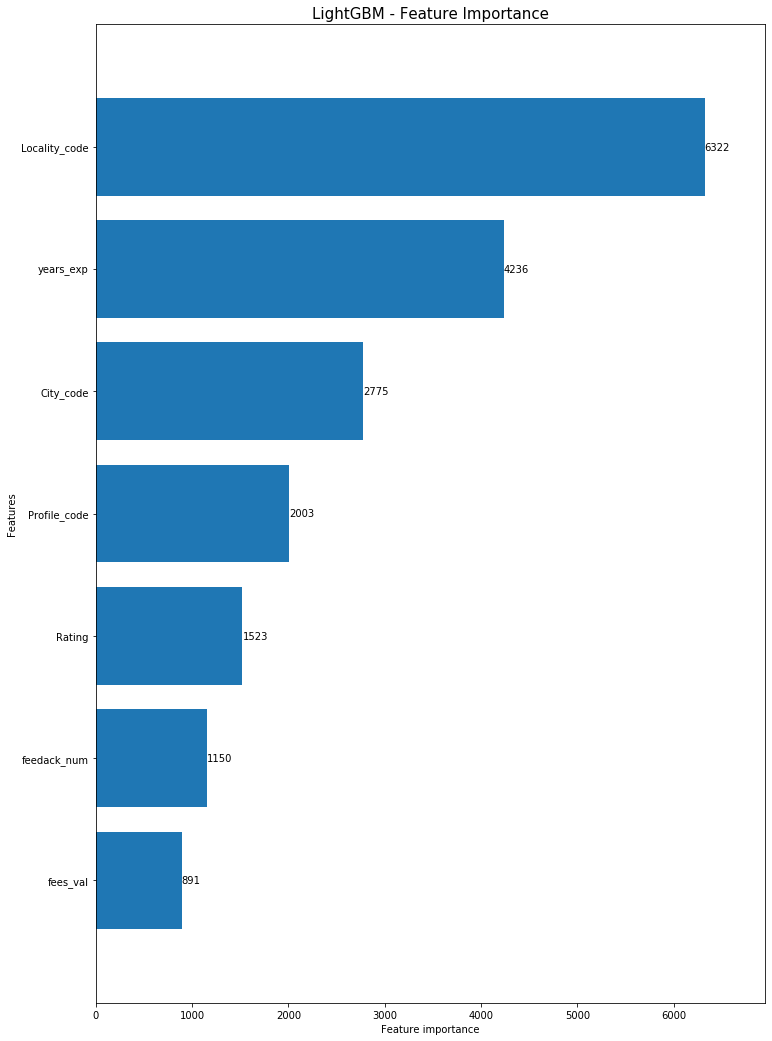

In [60]:
# plot feature importance of LGB
from sklearn import model_selection
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model,max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [61]:
# XGBoost CV
def modelfit(algo, train, test, features, label, cv_folds=5, early_stopping_rounds=50, metric="auc"):
    
    xgb_param = algo.get_xgb_params()
    xgtrain = xgb.DMatrix(train[features], label=train[label], feature_names=features)
    xgtest = xgb.DMatrix(test[features])
    cv_result = xgb.cv(params = xgb_param,
                      dtrain = xgtrain,
                      num_boost_round = algo.get_params()['n_estimators'],
                      nfold = cv_folds,
                      metrics = metric,
                      early_stopping_rounds = early_stopping_rounds
                     )
    
    
    #Fit the algorithm on the data
    model = xgb.train(xgb_param,
                      xgtrain,
                      num_boost_round = cv_result.shape[0],
                      verbose_eval=15
                      )
        
    #Predict on testing data:
    y_pred = model.predict(xgtest)
    
    #Display feature importance graph
    xgb.plot_importance(model);
    
    return y_pred

C:\Users\Shubham\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Shubham\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


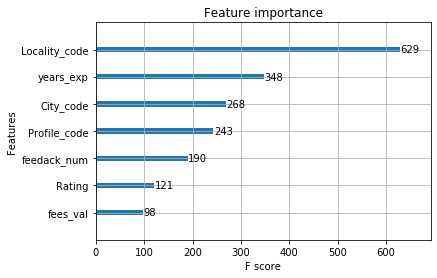

In [62]:
# Define Param and call function to execute XGBoost model

xgb1 = xgb.XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    gamma=0,
    objective= 'reg:linear',
    nthread=-1,
    seed=2019)

features = cols_to_use
label = target_col
train = train_df
test = test_df
pred_xgb = 0

pred_xgb = modelfit(xgb1, train, test, features, label, metric = 'rmse')

[23:59:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


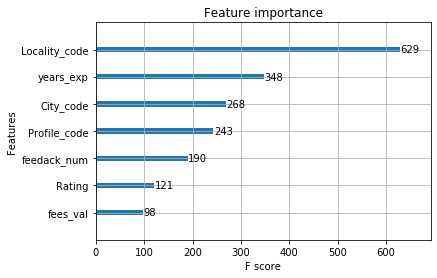

In [63]:
# Define Param and call function to execute XGBoost model

xgb1 = xgb.XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    gamma=0,
    objective= 'reg:linear',
    nthread=-1,
    seed=2019)

features = cols_to_use
label = target_col
train = train_df
test = test_df
pred_xgb = 0

pred_xgb = modelfit(xgb1, train, test, features, label, metric = 'rmse')

In [64]:

test_xgb = df_test
test_xgb['Fees'] = pred_xgb
test_xgb.to_csv('submission_xgb.csv')

In [65]:

df_test["Fees"] = 0.5*test_xgb["Fees"] + 0.5*test_lgb["Fees"]
df_test.to_csv("submission_average.csv", index=False)

In [69]:
from sklearn.externals import joblib
joblib.dump(kf,"Consultation_Fee.pkl")

['Consultation_Fee.pkl']